In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SyntaxError: unexpected EOF while parsing (<ipython-input-1-583db37e43a6>, line 17)

In [32]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



In [20]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print('All modules have been imported')

All modules have been imported


In [21]:
def make_dataframes(train_dir,test_dir):
    dirlist=[train_dir, test_dir]
    names=['train','test']
    zipdir=zip(names, dirlist)
    for name,d in zipdir:
        filepaths=[]
        labels=[]
        classlist=sorted(os.listdir(d) )       
        for klass in classlist:
            sklass=klass[:25] # use only first 25 characters of the class as some are very long
            classpath=os.path.join(d, klass)           
            flist=sorted(os.listdir(classpath)) 
            desc=f'{name:6s}-{sklass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(sklass)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1) 
        if name =='test':
            test_df=df       
        else:
            pdf=df
    # create a train_df and a valid_df
    train_df, valid_df = train_test_split(pdf, train_size=.9, shuffle=True, random_state = 123, stratify = pdf['labels'])
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)    
    return train_df, test_df, valid_df, classes, class_count

train_dir = r'/Users/amogh/Edi test/train'
test_dir=r'/Users/amogh/Edi test/test'
train_df, test_df, valid_df, classes, class_count=make_dataframes(train_dir, test_dir)

test  -Warts Molluscum and other: 100%|██████████████████████████████████████████████████| 272/272 [00:00<00:00, 272344.40files/s]


number of classes in processed dataset=  23
the maximum files in any class in train_df is  1264   the minimum files in any class in train_df is  191
train_df length:  14037   test_df length:  4175   valid_df length:  1560
average image height=  550   average image width=  647  aspect ratio h/w=  0.8500772797527048


In [30]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count

max_samples=300  # LIMIT MAXIMUM IMAGE SAMPLES IN ANY CLASS TO 160 IMAGES TO HELP BALANCE THE DATASET
min_samples=191
column='labels'
train_df, classes, class_count=trim(train_df, max_samples, min_samples, column)

dataframe initially is of length  11910  with  23  classes
after trimming, the maximum samples in any class is now  300  and the minimum samples in any class is  191
the trimmed dataframe now is of length  6635  with  23  classes


In [31]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

n=300
working_dir=r'./'
img_size = (224, 260) # img size will significantly impact training time
train_df=balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  6635
Found 234 validated image filenames.     for class   Poison Ivy Photos and oth    creating  66   augmented images 
Found 259 validated image filenames.     for class   Cellulitis Impetigo and o    creating  41   augmented images 
Found 191 validated image filenames.     for class        Urticaria Hives         creating  109  augmented images 
Found 216 validated image filenames.     for class   Hair Loss Photos Alopecia    creating  49   augmented images 
Total Augmented images created=  265
Length of augmented dataframe is now  6900


In [32]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size, use_scientific=False): 
    ycol='labels'
    trgen=ImageDataGenerator(horizontal_flip=True)    
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol , target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes


batch_size=30
use_scientific=False # if set to true will use scientific labels, otherwise use common name labels
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size,use_scientific=use_scientific)

Found 6865 validated image filenames belonging to 23 classes.          for train generator 
Found 1555 validated image filenames belonging to 23 classes.          for valid generator 
Found 4002 validated image filenames belonging to 23 classes.          for test generator 
test batch size:  25   test steps:  167  number of classes :  23


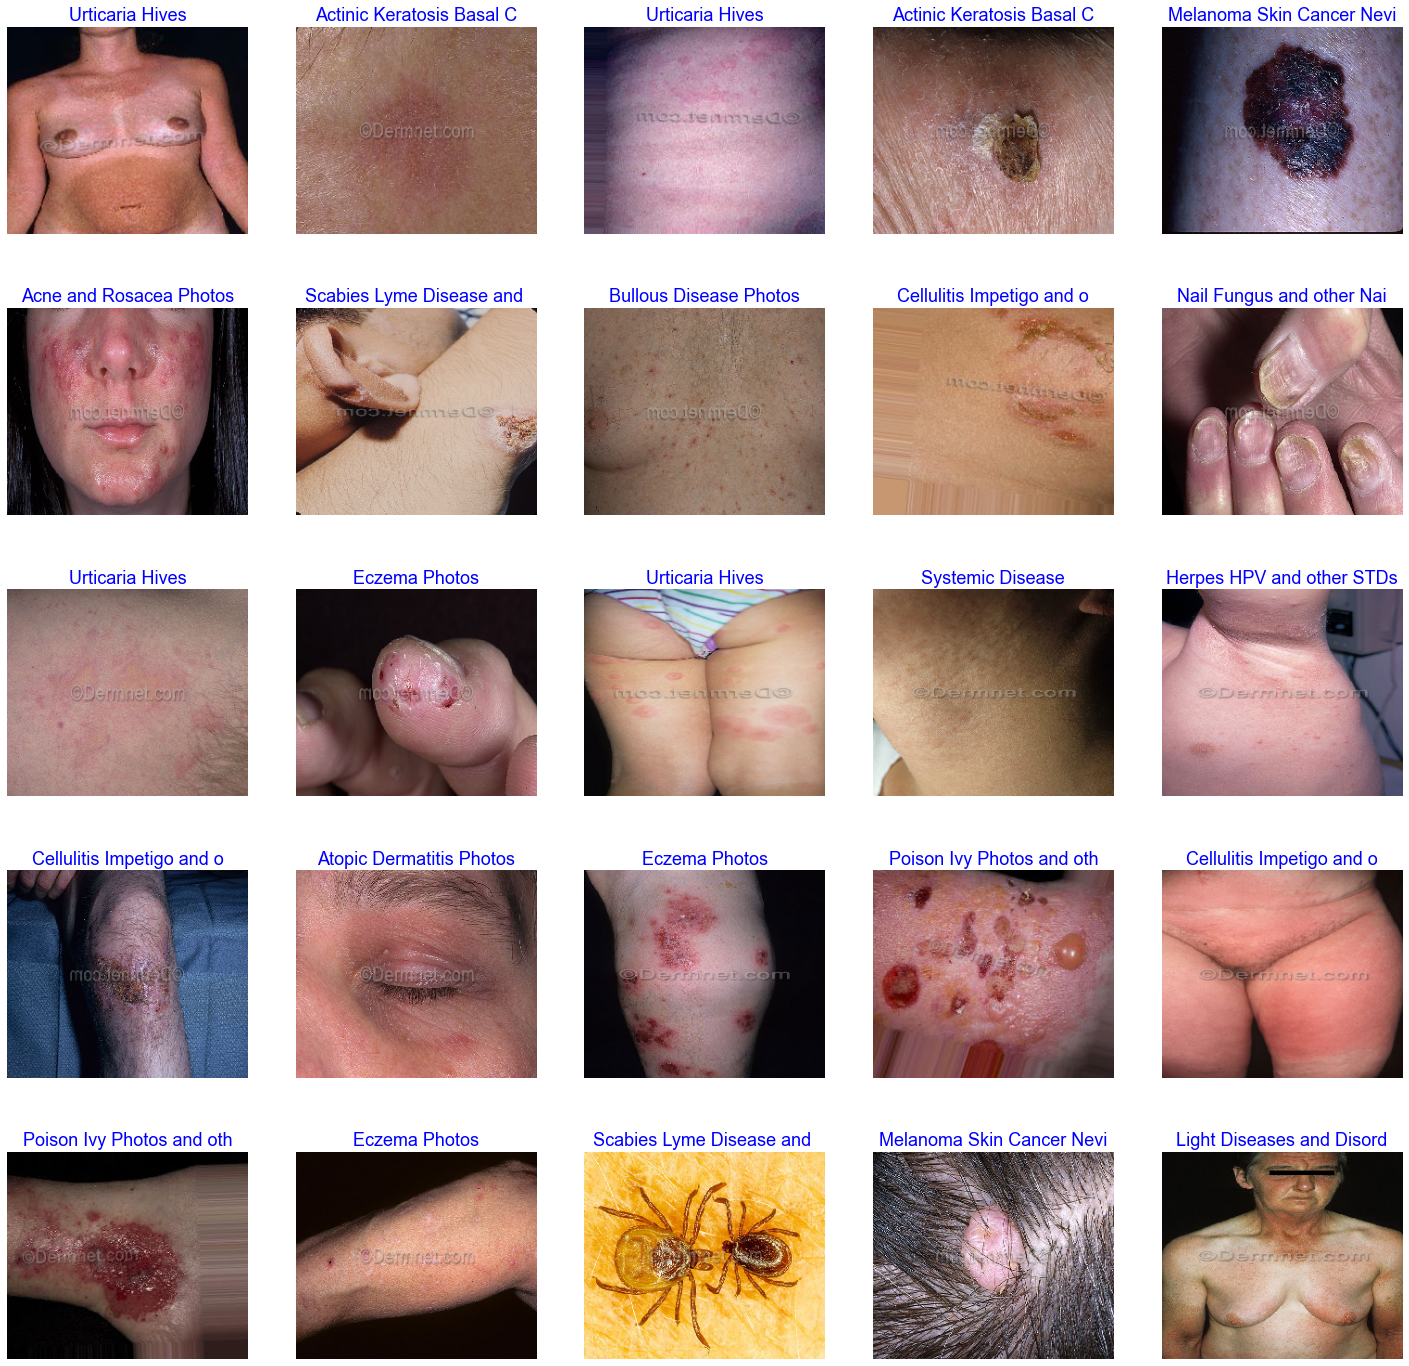

In [48]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [49]:
def make_model(img_size, lr, mod_num=3):  
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created VG19-3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B5 model'
        
    else:
        base_model=tf.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'   
   
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
    msg=msg + f' with initial learning rate set to {lr}'
    print(msg)
    return model

lr=.001
model=make_model(img_size, lr) # using B3 model by default

Created VG19-3 model with initial learning rate set to 0.001


In [39]:
def make_model(img_size, lr, mod_num=3):  
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B5 model'
        
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'   
   
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

lr=.001
model=make_model(img_size, lr) # using B3 model by default


Created EfficientNet B3 model with initial learning rate set to 0.001



In [35]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print(msg) # cyan foreground

In [48]:
epochs=40
ask_epoch=3
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

In [ ]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 3 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/40
706/920 [======================>.......] - ETA: 2:26 - loss: 0.2997 - accuracy: 0.9820

In [44]:
from tensorflow import keras
model = keras.models.load_model('EfficientNet 67.3823-(224 X 260)-67.14.h5')

In [54]:
base_model=tf.keras.applications.EfficientNetB3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [53]:
def make_model(img_size, lr, mod_num=3):  
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B5 model'
        
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'   
   
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
    msg=msg + f' with initial learning rate set to {lr}'
    print(msg)
    return model

lr=.001
model=make_model(img_size, lr) # using B3 model by default

NameError: name 'base_model' is not defined

In [55]:
base_model.load_weights('EfficientNet 67.3823-(224 X 260)-67.14.h5')

ValueError: Layer count mismatch when loading weights from file. Model expected 210 layers, found 212 saved layers.

In [44]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')    
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    return index_loss
    
loss_index=tr_plot(history,0)

NameError: name 'history' is not defined

167/167 [==============================] - 69s 394ms/step
there were 1362 errors in 4175 tests for an accuracy of  67.38



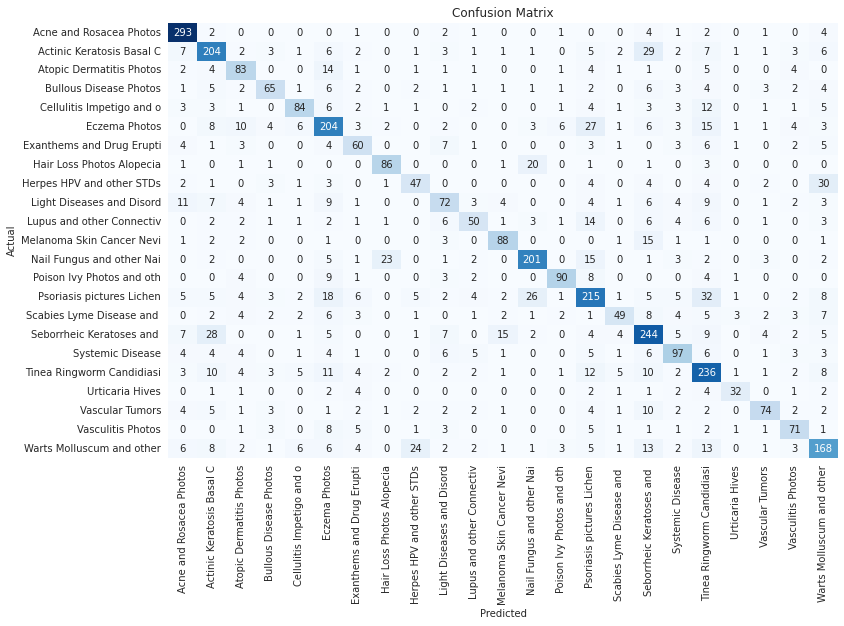

Classification Report:
----------------------
                            precision    recall  f1-score   support

  Acne and Rosacea Photos     0.8277    0.9391    0.8799       312
Actinic Keratosis Basal C     0.6711    0.7083    0.6892       288
 Atopic Dermatitis Photos     0.6148    0.6748    0.6434       123
   Bullous Disease Photos     0.6989    0.5752    0.6311       113
Cellulitis Impetigo and o     0.7500    0.6269    0.6829       134
            Eczema Photos     0.6182    0.6602    0.6385       309
Exanthems and Drug Erupti     0.5769    0.5941    0.5854       101
Hair Loss Photos Alopecia     0.7350    0.7478    0.7414       115
Herpes HPV and other STDs     0.5465    0.4608    0.5000       102
Light Diseases and Disord     0.5760    0.5035    0.5373       143
Lupus and other Connectiv     0.6250    0.4762    0.5405       105
Melanoma Skin Cancer Nevi     0.7395    0.7586    0.7489       116
Nail Fungus and other Nai     0.7761    0.7701    0.7731       261
Poison Ivy Pho

In [45]:
def predictor(test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)

In [46]:
if len(error_list) > 0 and len(error_list)<50:
    print ('Below is a list of test files that were miss classified \n')
    print ('{0:^30s}{1:^30s}'.format('Test File', ' Predicted as'))
    sorted_list=sorted(error_list)
    for i in range(len(sorted_list)):
        fpath=sorted_list[i]        
        split=fpath.split('\\')        
        f=split[4]+ '-' + split[5]
        print(f'{f:^30s}{error_pred_list[i]:^30s}')
else:
    msg='There we more than 50 classification errors'
    print_in_color(msg)

There we more than 50 classification errors



In [47]:
name='VG16 67.38' + str(len(classes)) + '-(' + str(img_size[0]) + ' X ' + str(img_size[1]) + ')'
save_id=f'{name}-{f1score:5.2f}.h5'
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
msg= f'model was saved as {model_save_loc}'
print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground

model was saved as ./EfficientNet 67.3823-(224 X 260)-67.14.h5



In [56]:
from tkinter import *
from tkinter.filedialog import askopenfilename

from PIL import Image, ImageTk

tk = Tk()

tk.minsize(1850,1000)
tk.maxsize(1920,1080)
# tk.config(bg="skyblue")
tk.title("SKIN DISEASE CLASSIFICATION")


title_frame = Frame(tk,height=30,width=1920)
title_frame.grid(row=0, column=0, padx=10, pady=5)

# tk.grid_rowconfigure(0, weight=1)
# tk.grid_columnconfigure(0, weight=1)



heading = Label(title_frame,text='SKIN DISEASE CLASSIFICATION', font=('Cambria',30, 'bold'))
heading.pack()


name = Label(tk,text="NAME  ",font=("Algerian",20))
age = Label(tk,text="AGE  ",font=("Algerian",20))
gender = Label(tk,text="GENDER  ",font=("Algerian",20))
duration = Label(tk,text="DURATION",font=("Algerian",20))

name.grid(row=8,column=0)
age.grid(row=10,column=0)
gender.grid(row=12,column=0)
duration.grid(row=14,column=0)

nameVal = StringVar()
ageVal = IntVar()
genderVal = StringVar()
durationVal = StringVar()

name_Input = Entry(tk,textvariable=nameVal)
age_Input = Entry(tk,textvariable=ageVal)
gender_Input = Entry(tk,textvariable=genderVal)
duration_Input = Entry(tk,textvariable=durationVal)

name_Input.grid(row=8,column=1)
age_Input.grid(row=10,column=1)
gender_Input.grid(row=12,column=1)
duration_Input.grid(row=14,column=1)


b1 = Button(tk, text='Upload File',
   width=20,command = lambda:upload_file())
b1.grid(row=16,column=1)

def upload_file():
    global img
    f_types = [('Jpg Files', '*.jpg')]
    filename = askopenfilename(filetypes=f_types)
    img = ImageTk.PhotoImage(file=filename)
    b2 =Button(tk,image=img) # using Button
    b2.grid(row=22,column=0)

def open():

    confidence_int=Label(tk,text="Confidence Interval = ",font=('Cambria',12, 'bold')).grid(row=22,column=1)
    confidence_interval=Label(tk,text=100 * np.max(score),font=('Cambria',12, 'bold')).grid(row=22,column=2)

    severity_label=Label(tk,text="Severity: ",font=('Cambria',12, 'bold')).grid(row=22,column=3)
    if 100 * np.max(score)>70:
        severity=Label(tk,text="Major",font=('Cambria',12, 'bold')).grid(row=22,column=4)

    elif 45<100 * np.max(score)<70:
        severity=Label(tk,text="Moderate",font=('Cambria',12, 'bold')).grid(row=22,column=4)
    elif 100 * np.max(score)<45:
        severity=Label(tk,text="Minor",font=('Cambria',12, 'bold')).grid(row=22,column=4)

    recovery_time=Label(tk,text="Recovery Time :",font=('Cambria',12, 'bold')).grid(row=24,column=3)

    location = Label(tk, text="Location of Disease :", font=('Cambria', 12, 'bold')).grid(row=25, column=3)

    disease=Label(tk,text="Disease =",font=('Cambria', 12, 'bold')).grid(row=23,column=3)

    if class_names=="Acne and Rosacea Photos" :
        disease_name=Label(tk,text="Acne and Rosacea",font=('Cambria', 12, 'bold')).grid(row=23,column=4)
        if 100 * np.max(score)>70:
            Recovery_time=Label(tk,text="2 Months",font=('Cambria',12, 'bold')).grid(row=24,column=4)
        elif 45 < np.max(score)<70:
            Recovery_time = Label(tk, text="4 Weeks",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score)<45:
            Recovery_time = Label(tk, text="2 Weeks",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Mainly affect the Face but can spread to neck and chest", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names=="Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions":
        disease_name = Label(tk, text="Actinic Keratosis Basal Cell Carcinoma ", font=('Cambria', 12, 'bold')).grid(row=23, column=4)
        if 100 * np.max(score)>70:
            Recovery_time = Label(tk, text="3 Months",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score)<70:
            Recovery_time = Label(tk, text="3 Weeks ",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score)<45:
            Recovery_time = Label(tk, text="2 Weeks ",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Sun-Exposed Areas like head, neck, forearms, hands,etc.", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names=="Eczema Photos":
        disease_name = Label(tk, text="Eczema", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score)>70:
            Recovery_time = Label(tk, text="1 Month",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score)<70:
            Recovery_time = Label(tk, text="3 Weeks ",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score)<45:
            Recovery_time = Label(tk, text="1 Week ",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Back of the Knees or Back, Inside of the Elbows", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names=="Seborrheic Keratoses and other Benign Tumors":
        disease_name = Label(tk, text="Seborrheic Keratoses", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="14 Days",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text="7 Days ",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="2-3 Days ",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Face, Neck, Chest, Back", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names=="Tinea Ringworm Candidiasi":
        disease_name = Label(tk, text="Tinea Ringworm Candidiasi", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="3 Months",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text="6 Weeks ",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="3 Weeks ",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Feet, Groins, Inner Thighs, Buttocks", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names=="Warts Molluscum and other Viral Infections":
        disease_name = Label(tk, text="Warts Molluscum ", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="4 Years",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text="6-12 Months ",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="3-4 Months ",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Stomach, Face, Arms, Legs, Nappy Area", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names=="Atopic Dermatitis Photos":
        disease_name = Label(tk, text="Atopic Dermatitis", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="May or may not be able to recover ",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text="2-4 Weeks ",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="1-2 Weeks",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Inside the Elbows, Behind the Knees, Infront of the Neck", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names=="Bullous Disease Photos":
        disease_name = Label(tk, text="Bullous Disease ", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="5 Years ",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text="1-2 Years ",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="5-6 Months",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Lower Abdomen, Upper Thighs, Armpits", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names=="Cellulitis Impetigo and other Bacterial Infections":
        disease_name = Label(tk, text="Cellulitis Impetigo ", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="2 Weeks ",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text="7-10 Days ",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="5-7 Days",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Nose and Mouth", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names=="Exanthems and Drug Eruptions":
        disease_name = Label(tk, text="Exanthems ", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="2 Weeks ",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text="10 Days ",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="2-4 Days",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Appear anywhere on the body but ofter starts on face or trunks", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names=="Hair Loss Photos Alopecia and other Hair Diseases":
        disease_name = Label(tk, text="Alopecia ", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="Around 1 Year ",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text="5-6 Months ",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="3-4 Months",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Scalp, Beard Area, Eyebrows, Eyelashes, Armpits, Inside Nose or Ears", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names=="Herpes HPV and other STDs Photos":
        disease_name = Label(tk, text="Herpes HPV ", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="3 Weeks ",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text="10-12 Days ",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="5-7 Days",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Genitals, Rectum or Mouth", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names=="Light Diseases and Disorders of Pigmentation":
        disease_name = Label(tk, text="Disorders of Pigmentation", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="Few Years",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text="6-12 Months ",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="2-3 Months",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Skin Colour", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names=="Lupus and other Connective Tissue diseases":
        disease_name = Label(tk, text="Lupus", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="Few Months",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text=" 3-4 Weeks",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="10-12 Days",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Joints, Skin, Kidneys, Blood Cells, Brain, Heart, Lungs", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names=="Melanoma Skin Cancer Nevi and Moles":
        disease_name = Label(tk, text="Melanoma", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="No Recovery. 5 Years of survival Rate (Stage 4)",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text=" 1-2 Weeks",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="5-7 Days",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Areas having exposure to Sun, like Back, Legs, Arms, Face", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names=="Nail Fungus and other Nail Disease":
        disease_name = Label(tk, text="Nail Fungus", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="18 Months",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text=" 12-14 Months",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="6-7 Months",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Fingernail, Toenail", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names=="Poison Ivy Photos and other Contact Dermatitis":
        disease_name = Label(tk, text="Poison Ivy and other Contact Dermatitis", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="1 Months",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text=" 2-3 Weeks",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="1 Week",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Can Transfer to entire body by touching or rubbing", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names=="Psoriasis pictures Lichen Planus and related diseases":
        disease_name = Label(tk, text="Lichen Planus", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="1 Year",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text="8-10 Months",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="1-2 Months",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Wrist, Ankles or lower Back", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names=="Scabies Lyme Disease and other Infestations and Bites":
        disease_name = Label(tk, text="Scabies Lyme", font=('Cambria', 12, 'bold')).grid(row=23, column=4)


        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="1-1.5 Months",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text="3-4 Weeks",font=('Cambria',12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="1-2 Weeks",font=('Cambria',12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Armpits, Fingers, Toes, Inner Elbows, Soles of the Feet, Chest", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names == "Systemic Disease":
        disease_name = Label(tk, text="Systemic Disease", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="43-45 Days", font=('Cambria', 12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text="25-30 Days", font=('Cambria', 12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="19-20 Days", font=('Cambria', 12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Entire Body", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names == "Urticaria Hives":
        disease_name = Label(tk, text="Urticaria Hives", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="2 Weeks", font=('Cambria', 12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text="1-1.5 Weeks", font=('Cambria', 12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="5-7 Days", font=('Cambria', 12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Any Area of the Body", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names == "Vascular Tumors":
        disease_name = Label(tk, text="Vascular Tumors", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="4-6 Weeks", font=('Cambria', 12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text="1-2 Weeks", font=('Cambria', 12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="3-5 Days", font=('Cambria', 12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Anywhere on the Body", font=('Cambria', 12, 'bold')).grid(row=25, column=4)

    elif class_names == "Vasculitis Photos":
        disease_name = Label(tk, text="Vasculitis", font=('Cambria', 12, 'bold')).grid(row=23, column=4)

        if 100 * np.max(score) > 70:
            Recovery_time = Label(tk, text="3-4 Weeks", font=('Cambria', 12, 'bold')).grid(row=24, column=4)
        elif 45 < np.max(score) < 70:
            Recovery_time = Label(tk, text="1-1.5 Weeks", font=('Cambria', 12, 'bold')).grid(row=24, column=4)
        elif np.max(score) < 45:
            Recovery_time = Label(tk, text="5-7 Days", font=('Cambria', 12, 'bold')).grid(row=24, column=4)

        general_location=Label(tk, text="Capillaries, Medium-Sized Blood vessels or Aorta", font=('Cambria', 12, 'bold')).grid(row=25, column=4)


# def make_model(img_size, lr, mod_num=3):
#     img_shape = (img_size[0], img_size[1], 3)
#     if mod_num == 0:
#         base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",
#                                                                        input_shape=img_shape, pooling='max')
#         msg = 'Created EfficientNet B0 model'
#     elif mod_num == 3:
#         base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",
#                                                                        input_shape=img_shape, pooling='max')
#         msg = 'Created EfficientNet B3 model'
#     elif mod_num == 5:
#         base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",
#                                                                        input_shape=img_shape, pooling='max')
#         msg = 'Created EfficientNet B5 model'
#
#     else:
#         base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",
#                                                                        input_shape=img_shape, pooling='max')
#         msg = 'Created EfficientNet B7 model'
#
#     base_model.trainable = True
#     x = base_model.output
#     x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
#     x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
#               bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
#     x = Dropout(rate=.4, seed=123)(x)
#     output = Dense(class_count, activation='softmax')(x)
#     model = Model(inputs=base_model.input, outputs=output)
#     model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
#     msg = msg + f' with initial learning rate set to {lr}'
#     print_in_color(msg)
#     return model


# lr = .001
# model = make_model(img_size, lr)  # using B3 model by default'''


result = Button(tk,text='RESULT',command=open)
result.grid(row=20,column=1)





tk.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "<ipython-input-56-3a6931a6b201>", line 67, in open
    confidence_interval=Label(tk,text=100 * np.max(score),font=('Cambria',12, 'bold')).grid(row=22,column=2)
NameError: name 'score' is not defined
